# Block Ciphers

In [11]:
from blockciphers import aes_image_encryption, aes_mcs_diffusion, aes_mcs_confusion
from Crypto.Cipher import AES
import os
from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np

## Introduction

**Block Ciphers** are symmetric ciphers that split the plaintext in fixed size blocks and encrypt them using the same key. Typically the encryption is made of many **rounds**, all constituted by the same set of simpler transformations, so that the final ciphertext is more secure than the intermediate ones. To guarantee security, some tranformations are linear to provide diffusion and others are non linear to provide confusion.

If blocks are encrypted independently one from another, even very performant block ciphers don't provide good security because statistical regularities and patterns of the plaintext may be recognized analyzing the chiphertext (similarly to Substitution Ciphers). For this reason several **Modes of Operations** were proposed, where the current ciphertext block depends not only on the respective plaintext block.

This notebook will focus on **Advanced Encryption Standard (AES)**, with the objective of seeing how different Modes of Operations work and to assess the level of diffusion and confusion this algorithm is capable to provide.

## AES

**AES**, originally named *Rijndael*, was firstly proposed in 1998 as a candiate for a NIST challenge that it officially won in 2000. Its main characteristics are:
- fixed block size of 16 bytes.
- key length of 16, 24 or 32 bytes.
- 10, 12 or 14 rounds depending on the key length.

The encryption process is made of two parts:
- Key Schedule: it takes as input the key and produces 16 bytes round keys needed for the encryption. The round keys can be produced while the encryption goes on since they are used in the same order as they are computed.
- Datapath: it is the sequence of rounds the plaintext goes through. Each round is composed by three layers:
    - Linear Mixing Layer: it constitutes the linear transformation providing diffusion. It is divided into two sub-transformations, respectively called *Shift Rows* and *Mixing Columns*.
    - Non Linear Layer or Byte Substitution: it constitutes the non linear transformation providing confusion.
    - Key Addition Layer: it takes as inputs the intermediate ciphertext and the round key and XOR them together.

To decrypt a ciphertext, one need to compute all the inverse transformations and apply them in the opposite order with respet to encryption. The only issue is that all the round keys must be computed before starting with the real decryption since the first to be used is the last to be produced.

![AES structure](AES.jpg)

In [12]:
# Open the PNG image
image_path = 'image.png'

# Generate a random 128 bits key
random_key = os.urandom(16)

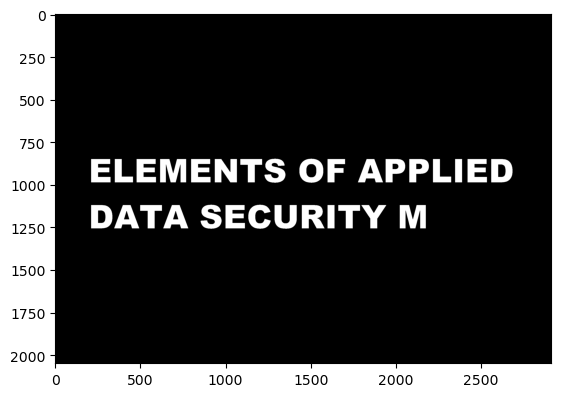

In [13]:
image = imread(image_path).mean(axis=-1)
image = 255 * image.astype(np.uint8)
plt.imshow(image, cmap='gray');

### Electronic Code Book (ECB)

With the **ECB Mode of Operation**, each block is encrypted independently from the others. As it has already been suggested, this method does not provide good security because statistical properties of the plaintext may be found also in the ciphertext.

Looking at the encrypted image below, one can easily recognize the text.

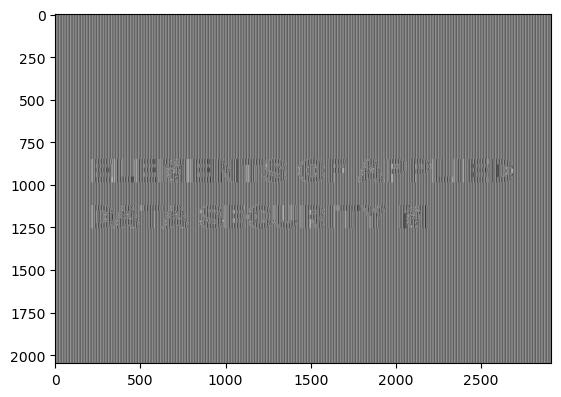

In [14]:
# Instantiate AES with ECB mode of operation
aes_ecb = AES.new(random_key, AES.MODE_ECB)
# Encrypt the image
aes_image_encryption(aes_ecb, 'ECB', image)

### Cipher Block Chaining (CBC)

If one uses **CBC Mode of Operation**, each plaintext block is XORed with the previous ciphertext block before being encrypted: in this way blocks are not independent anymore and statistical regularities of the plaintext can be better hidden. The first block is XORed togehter with an **Initialization Vector (IV)** that is kept secret and usually is a **NONCE (Number Used Once)**.

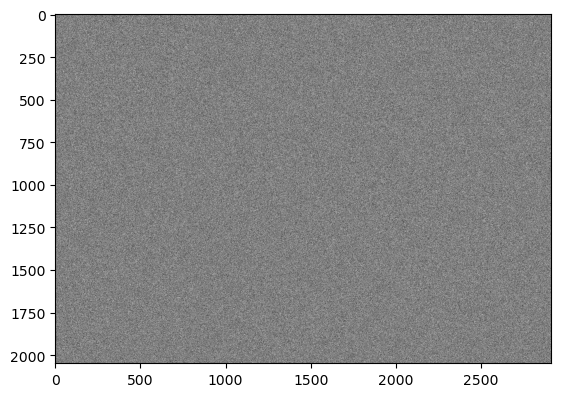

In [15]:
# Instantiate AES with CBC mode of operation
aes_cbc = AES.new(random_key, AES.MODE_CBC)
# Encrypt the image
aes_image_encryption(aes_cbc, 'CBC', image)

### Cipher Feedback (CFB)

in **CFB Mode of Operation**, the block cipher is used as building element for a stream cipher: each keystream block, eventually XORED with the respective plaintext block, is the result of the encryption of the previous ciphertext block. Also in this case the first keystream block is computed starting form an Initialization Vector.

Since blocks are not treated as independent entities, the final ciphertext is much more secure.

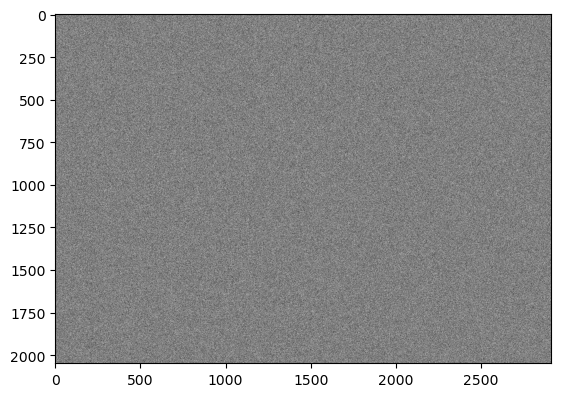

In [16]:
# Instantiate AES with CFB mode of operation
aes_cfb= AES.new(random_key, AES.MODE_CFB)
# Encrypt the image
aes_image_encryption(aes_cfb, 'CFB', image)

### Counter (CTR)

In **CTR Mode of Operation** a stream cipher is built and the keystream blocks are the result of the block cipher's encryption of particular blocks made of two parts: the first is a NONCE and the second is the output of a counter. Since each plaintext block is encrypted always with a brand new keystream, the ciphertext is secure and no patterns can be detected. In addition, consecutive blocks are not dependent, then both encryption and decryption can be **parallelized**, making this method very efficient.

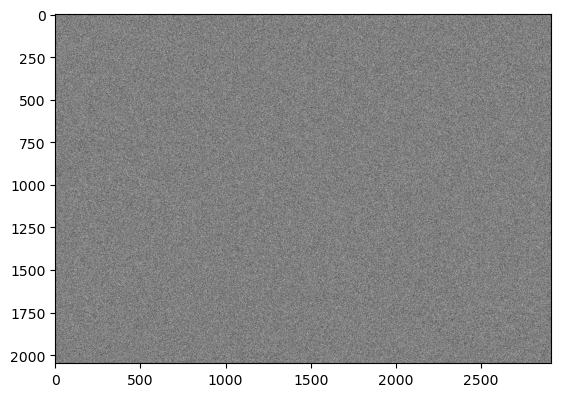

In [17]:
# Instantiate AES with CTR mode of operation
aes_ctr = AES.new(random_key, AES.MODE_CTR)
# Encrypt the image
aes_image_encryption(aes_ctr, 'CTR', image)

## Monte Carlo Simulation

**Monte Carlo Methods** are a series of algorithms that try to gather some information or numerical result by means of **repeated random sampling**. The general proceudre is the following:
- define the input domain .
- draw some random samples in the domain given a certain probability distribution.
- measure or compute the quantity you are interested in for each sample.
- combine the results.

### $\pi$ estimation


A well known application of Monte Carlo simulation is the **estimation of $\pi$**.

Given a square of side 2 and a circle of radius 1 inscribed in it, the following relation is true:$$\frac{A_{circle}}{A_{square}} = \frac{\pi r^2}{(2r)^2} = \frac{\pi r^2}{4r^2} = \frac{\pi}{4} \Rightarrow \pi = 4\frac{A_{circle}}{A_{square}}$$

The ration between the two areas can be estimated drawing some uniformly distributed random points inside the square and computing the ratio between the number of points inside the circle and the total number of samples. The domain can also be reduced to only a quarter of the square since the proportion between the two areas remains the same.

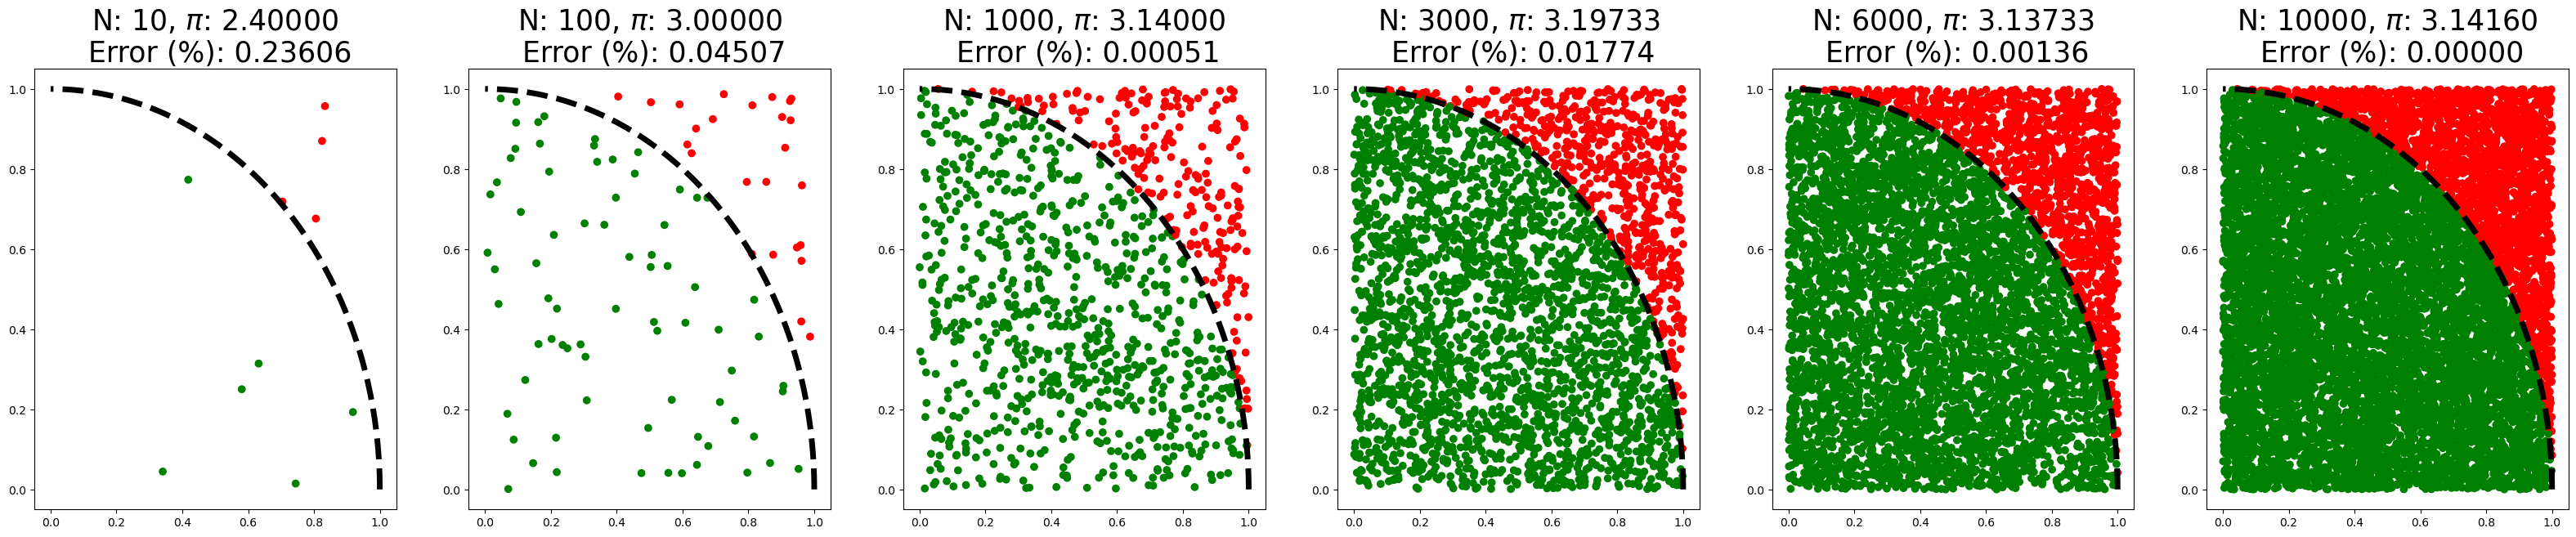

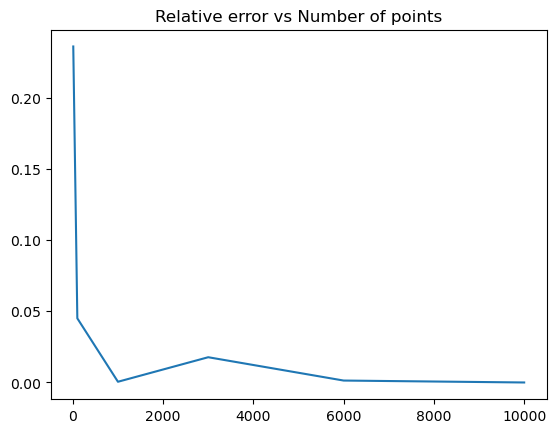

In [18]:
n_points = [10, 100, 1000, 3000, 6000, 10000]

fig1, axs1 = plt.subplots(1, len(n_points), figsize=(40, 7))

# Points to plot the quarter of circle
theta = np.linspace(0, np.pi/2, 100)
x_circle = np.cos(theta)
y_circle = np.sin(theta)

# Lists containg the pi estimations and the respective relative errors
pi_est = []
err = []
for a, n in enumerate(n_points):
    # Number of points falling inside the circle
    circle_points = 0
    colors = []
    # Randomly drawn points coordinates
    x_coord = np.random.rand(n)
    y_coord = np.random.rand(n)
    #Counting how many points are inside the circle
    for x, y in zip(x_coord, y_coord):
        if np.linalg.norm((x, y)) <= 1:
            colors.append('green')
            circle_points += 1
        else:
            colors.append('red')

    # Compute pi estimation and respective relative error       
    pi_est.append(4*circle_points/n)
    err.append(np.abs(pi_est[a] - np.pi)/np.pi)

    axs1[a].scatter(x_coord, y_coord, c=colors)
    axs1[a].plot(x_circle, y_circle, linestyle='--', linewidth=5, color='black')
    axs1[a].set_title(f'N: {n}, $\pi$: {pi_est[a]:.5f}\n Error (%): {err[a]:.5f}', fontsize = 25)

plt.figure()
plt.plot(n_points, err)
plt.title('Relative error vs Number of points');

Analyzing the results of the experiment, one can notice that the relative error is subject to a very rapid improvement in the fisrt trials and remains practically the same when the number of samples gets higher and higher. This means that, after a certain point, the additional computational complexity of a new iteration is not justified by a sufficient improvement in accuracy.

However, we may not know the true value of the quantity that we are trying to estimate, then we may not be able to compute the estimation error. In this case one strategy could be to measure the difference between two consecutive estimations and stop the algorithm if it becomes lower than a certain threshold.

## AES Diffusion and Confusion

### Diffusion

The role of **diffusion** is to hide the statistical relationship between plaintext and ciphertext. At bit level, this is achieved if, flipping one bit of the plaintext, half of the bit of the ciphertext change in average.

To test if AES provides good diffusion, we can apply the Monte Carlo approach as follows:
- we generate a plaintext of length **L** and we encrypt into the respective ciphertext
- we build a new ciphertext by flipping one rndom bit of the initial one and we encrypt it.
- we compare the new ciphertext with the original one and we count how many bits have changed (compute the **Hamming distance**).
- after repeating this process **N times**, we plot the distribution of the Hamming distance and we check if it is centered around **L/2**

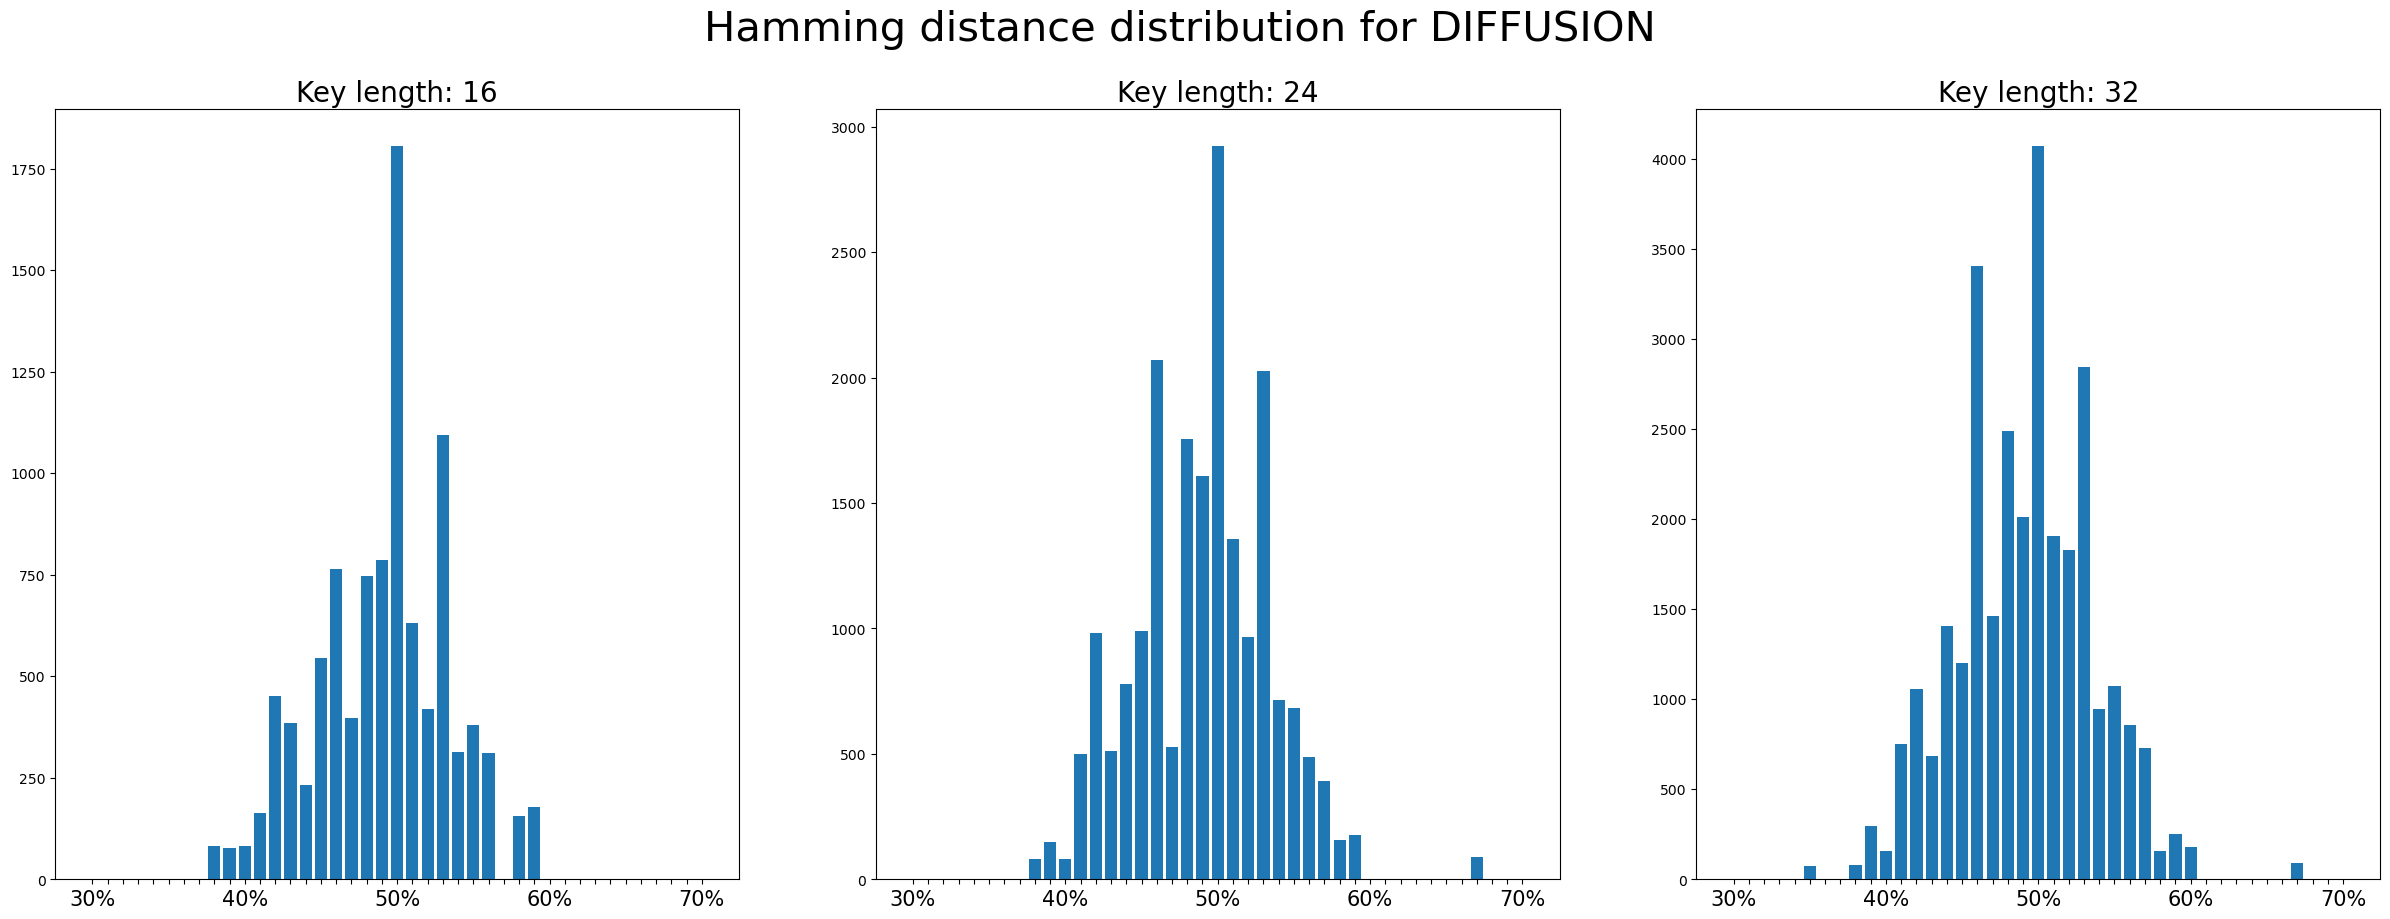

In [19]:
import os
import matplotlib.pyplot as plt
from Crypto.Cipher import AES

iterations = 10000
fig, axs = plt.subplots(1, len(AES.key_size), figsize=(30, 10))
fig.suptitle('Hamming distance distribution for DIFFUSION', fontsize=30)

# Dictionary for the hamming distance distribution
diff_dict = {f"{i}%": 0 for i in range(30, 71)}
x_labels = diff_dict.keys()
x_ticks = range(0, len(x_labels))

for idx, length in enumerate(AES.key_size):
    # Generate random key of 16, 24 or 32 bytes
    key = os.urandom(length)
    # Instantiate AES cipher
    # ECB Mode encrypt each block independently, then any modification int the
    # ciphertext or the key is directly mapped on the ciphertext, then this is
    # the best Mode of Operation to assess diffusion and confusion
    aes_ecb = AES.new(key, AES.MODE_ECB)
    # Generate a random 128 bits plaintext
    ref_plaintext = os.urandom(AES.block_size)
    # Encrypt the plaintext
    ref_ciphertext = bytearray(aes_ecb.encrypt(ref_plaintext))

    # Compute the list of hamming distances (as %) comparing the original
    # ciphertext with the ones obtained flipping a random bit in the plaintext
    dist = aes_mcs_diffusion(aes_ecb, ref_plaintext, ref_ciphertext, iterations)

    # Counting how many outcomes per percentage
    for value in dist:
        for i in range(30, 71):
            if i <= value < i + 1:
                diff_dict[f"{i}%"] += 1
                break

    axs[idx].bar(range(len(x_labels)), diff_dict.values())
    axs[idx].set_title(f'Key length: {length}', fontsize=20)
    axs[idx].set_xticks(x_ticks)
    axs[idx].set_xticklabels(['' if label not in ['30%', '40%', '50%', '60%', '70%'] 
                              else label for label in x_labels], fontsize=15)  # Set subset of labels

plt.show()


### Confusion

The purpose of **confusion** is to hide any statistical relationship between key and ciphertext. At bit level, this is achieved if each ciphertext bit depends on many key bits.

To test if AES provides good confusion, we can apply the same Monte Carlo approach as before, but this time we should keep untouched the plaintext and modify some random bits of the key. The expected result is again to obtain a distibution centered around L/2.

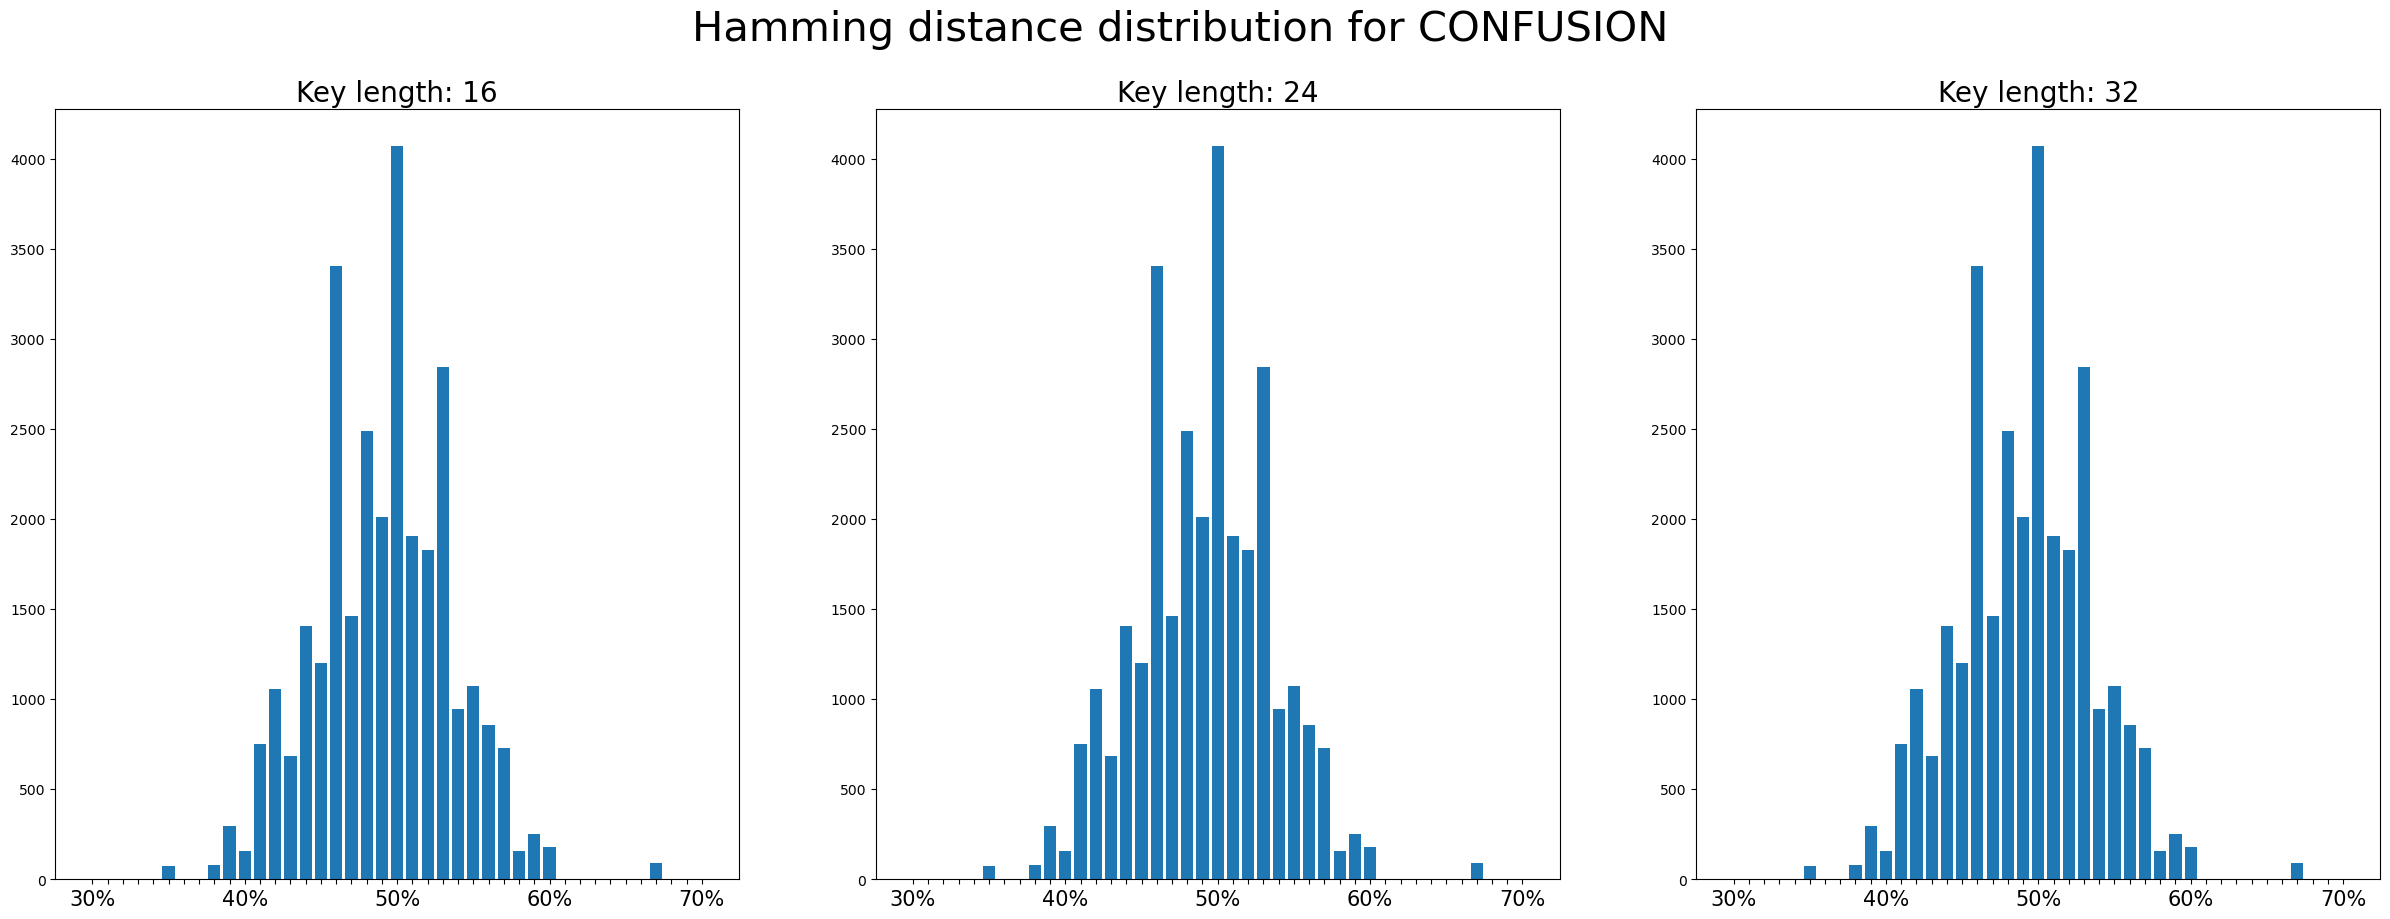

In [20]:
iterations = 10000

fig, axs = plt.subplots(1, len(AES.key_size), figsize=(30, 10))
fig.suptitle('Hamming distance distribution for CONFUSION', fontsize=30)

conf_dict = {f"{i}%": 0 for i in range(30, 71)}

for idx, length in enumerate(AES.key_size):
    # Generate random key of 16, 24 or 32 bytes
    key = os.urandom(length)
    # Instantiate AES cipher
    # ECB Mode encrypt each block independently, then any modification int the
    # ciphertext or the key is directly mapped on the ciphertext, then this is
    # the best Mode of Operation to assess diffusion and confusion
    aes_ecb = AES.new(key, AES.MODE_ECB)
    # Generate a random 128 bits plaintext
    ref_plaintext = os.urandom(AES.block_size)
    # Encrypt the plaintext
    ref_ciphertext = bytearray(aes_ecb.encrypt(ref_plaintext))

    # Compute the list of hamming distances (as %) comparing the original
    # ciphertext with the ones obtained flipping a random bit in the key
    dist = aes_mcs_confusion(key, length, ref_plaintext, ref_ciphertext, iterations)

    for value in dist:
        for i in range(30, 71):
            if i <= value < i + 1:
                conf_dict[f"{i}%"] += 1
                break
            
    axs[idx].bar(range(len(x_labels)), diff_dict.values())
    axs[idx].set_title(f'Key length: {length}', fontsize=20)
    axs[idx].set_xticks(x_ticks)
    axs[idx].set_xticklabels(['' if label not in ['30%', '40%', '50%', '60%', '70%'] 
                              else label for label in x_labels], fontsize=15)  # Set subset of labels